## <center> Final Project </center> 
### <center> -- Austin Bikeshare Analysis -- </center>
#### <center> Asad Husain </center> 

Hola!
In this project, I'd like to analyse the Austin's bikeshare data for the years 2014 and 2015. 
I've written the details about this dataset, my methodology, and reuslts, in the pdf file attached.
Let's begin.

<center><img src="austin map.png" width=400 height=400 /></center>
<center> Map of Metro Bike kiosk hotspots in Austin, Texas </center>

In [1]:
#Install these packages first if not present
##pip install networkx
##pip install pulp
##pip install geopy
##!pip install xgboost
##!pip install sklearn

In [1]:
#importing necessary libraries
import pandas as pd #handling data
import numpy as np #handling numbers and matrices
import matplotlib.pyplot as plt #making plots
import networkx as nx #making graphs
import pulp #solving linear optimization problems
import random
pd.options.display.max_columns = 999
import warnings
warnings.filterwarnings("ignore")
import geopy.distance
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pulp import *
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

#### Importing and Cleaning data

In [2]:
dt_full = pd.read_csv("Bikeshare_Austin_compiled.csv")

In [3]:
dt_full.head(3)

,Trip_ID,Membership_Type,Bicycle_ID,Checkout_Date,Month,TempAvgF,DewPointAvgF,HumidityAvgPercent,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,Checkout_Kiosk_ID,Checkout_Kiosk,Checkout_Kiosk_latitude,Checkout_Kiosk_longitude,Return_Kiosk_ID,Return_Kiosk,Return_Kiosk_latitude,Return_Kiosk_longitude,Trip_Duration_Minutes
0,9900285854,Annual (San Antonio B-cycle),207,10/26/2014,10,74,58,62,10,4,0.0,2537,West & 6th St.,30.27041,-97.75046,2707,Rainey St @ Cummings,30.25579,-97.73982,76
1,9900285855,24-Hour Kiosk (Austin B-cycle),969,10/26/2014,10,74,58,62,10,4,0.0,2498,Convention Center / 4th St. @ MetroRail,30.26483,-97.73900,2566,Pfluger Bridge @ W 2nd Street,30.26717,-97.75484,58
2,9900285856,Annual Membership (Austin B-cycle),214,10/26/2014,10,74,58,62,10,4,0.0,2537,West & 6th St.,30.27041,-97.75046,2496,8th & Congress,30.26980,-97.74186,8


In [4]:
dt_full["Checkout_Date"] = dt_full["Checkout_Date"].apply(pd.to_datetime)

In [5]:
#Disregarding the trips which lasted less than 2 minutes
dt_full = dt_full[dt_full["Trip_Duration_Minutes"] > 2]
dt_full = dt_full.reset_index().drop(columns = "index", axis = 1)

In [6]:
dt_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130943 entries, 0 to 130942
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Trip_ID                   130943 non-null  int64         
 1   Membership_Type           130943 non-null  object        
 2   Bicycle_ID                130943 non-null  int64         
 3   Checkout_Date             130943 non-null  datetime64[ns]
 4   Month                     130943 non-null  int64         
 5   TempAvgF                  130943 non-null  int64         
 6   DewPointAvgF              130943 non-null  int64         
 7   HumidityAvgPercent        130943 non-null  int64         
 8   VisibilityAvgMiles        130943 non-null  int64         
 9   WindAvgMPH                130943 non-null  int64         
 10  PrecipitationSumInches    130943 non-null  float64       
 11  Checkout_Kiosk_ID         130943 non-null  int64         
 12  Ch

In [7]:
dt_full.describe()

,Trip_ID,Bicycle_ID,Month,TempAvgF,DewPointAvgF,HumidityAvgPercent,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,Checkout_Kiosk_ID,Checkout_Kiosk_latitude,Checkout_Kiosk_longitude,Return_Kiosk_ID,Return_Kiosk_latitude,Return_Kiosk_longitude,Trip_Duration_Minutes
count,1.309430e+05,130943.000000,130943.000000,130943.000000,130943.000000,130943.000000,130943.000000,130943.000000,130943.000000,130943.000000,130943.000000,130943.000000,130943.000000,130943.000000,130943.000000,130943.000000
mean,9.900175e+09,437.793994,6.619942,72.014632,56.883163,64.506572,9.293738,5.158397,1.009394,2541.797691,30.265651,-97.745155,2539.627059,30.265476,-97.745126,30.070466
std,9.782433e+04,300.732377,3.086440,11.862285,13.613298,12.114999,1.309328,2.155350,2.919419,53.213339,0.007474,0.008531,52.599374,0.007224,0.008174,71.999591
min,9.900000e+09,3.000000,1.000000,29.000000,8.000000,27.000000,2.000000,1.000000,0.000000,2494.000000,30.248910,-97.771200,2494.000000,30.248910,-97.771200,3.000000
25%,9.900097e+09,190.000000,4.000000,63.000000,48.000000,59.000000,9.000000,4.000000,0.000000,2499.000000,30.262000,-97.750190,2499.000000,30.262000,-97.749710,9.000000
50%,9.900183e+09,387.000000,7.000000,74.000000,62.000000,66.000000,10.000000,5.000000,0.000000,2541.000000,30.264830,-97.743780,2539.000000,30.264830,-97.743780,15.000000
75%,9.900266e+09,663.000000,10.000000,83.000000,68.000000,71.000000,10.000000,7.000000,0.010000,2565.000000,30.269600,-97.739820,2564.000000,30.269600,-97.739820,27.000000
max,9.900343e+09,1000.000000,12.000000,92.000000,74.000000,97.000000,10.000000,11.000000,10.000000,2823.000000,30.285760,-97.710070,2823.000000,30.285760,-97.710070,6685.000000


In [8]:
dt_full.describe(include = ['O'])

,Membership_Type,Checkout_Kiosk,Return_Kiosk
count,130943,130943,130943
unique,30,44,44
top,24-Hour Kiosk (Austin B-cycle),City Hall / Lavaca & 2nd,City Hall / Lavaca & 2nd
freq,89050,7837,9183


In [9]:
#Calculating distance in Km between 2 sets of latitude and longitudes
def distance(lat1, lon1, lat2, lon2):
    
    coords_1 = (lat1, lon1)
    coords_2 = (lat2, lon2)

    return geopy.distance.distance(coords_1, coords_2).miles

In [10]:
dist = []
for i in range(dt_full.shape[0]):
    dist.append(distance(dt_full["Checkout_Kiosk_latitude"][i], dt_full["Checkout_Kiosk_longitude"][i],
                         dt_full["Return_Kiosk_latitude"][i], dt_full["Return_Kiosk_longitude"][i]))
dt_full["Distance"] = [round(x,2) for x in dist]

In [11]:
#Calculating revenue from the ride

#Cost Card
base_rate = 1 #fixed to unlock
variable_rate = 0.23 #per minute after that

def rev_calc(duration):
    return base_rate + (duration)*variable_rate

In [12]:
#Appending a revenue column to our table
rev = []
for i in range(dt_full.shape[0]):
    rev.append(rev_calc(dt_full["Trip_Duration_Minutes"][i]))
dt_full["Revenue"] = [round(x,2) for x in rev]

#### Problem - Travelling Salesman Problem

Now we make a graph with checkout kiosks and return kiosks as nodes and distance as the edge strength. 

In [13]:
trips = pd.DataFrame(dt_full.groupby(by = ["Checkout_Kiosk_ID","Return_Kiosk_ID"])
                     .size().sort_values(ascending = False).reset_index())
diff_trips = trips
diff_trips.rename(columns={0: 'NoOfTrips'}, inplace = True)
diff_trips.reset_index(inplace = True)
diff_trips.drop(columns = 'index', inplace = True)

In [14]:
dist = pd.DataFrame(dt_full.groupby(["Checkout_Kiosk_ID", "Return_Kiosk_ID"])
                   ["Distance"].mean().reset_index())
diff_trips = pd.merge(diff_trips, dist, on = ["Checkout_Kiosk_ID", "Return_Kiosk_ID"])

tdm = pd.DataFrame(dt_full.groupby(["Checkout_Kiosk_ID", "Return_Kiosk_ID"])
                   ["Trip_Duration_Minutes"].mean().reset_index())
diff_trips = pd.merge(diff_trips, tdm, on = ["Checkout_Kiosk_ID", "Return_Kiosk_ID"])
diff_trips.rename(columns={"Trip_Duration_Minutes": 'AvgTripDuration'}, inplace = True)

In [15]:
diff_trips

,Checkout_Kiosk_ID,Return_Kiosk_ID,NoOfTrips,Distance,AvgTripDuration
0,2575,2575,1768,0.00,53.033371
1,2499,2499,1210,0.00,75.216529
2,2497,2497,931,0.00,59.085929
3,2502,2502,880,0.00,77.948864
4,2550,2501,841,0.40,6.602854
...,...,...,...,...,...
1819,2569,2712,1,1.71,22.000000
1820,2569,2545,1,1.09,8.000000
1821,2544,2541,1,2.01,28.000000
1822,2823,2538,1,2.36,25.000000


In [16]:
#Function to calculate distance travelled in a path
def path_dist(path):    
    travel = 0
    for i in range(len(path)-1):

        val = diff_trips[(diff_trips["Checkout_Kiosk_ID"] == path[i]) & (diff_trips["Return_Kiosk_ID"] == path[i+1])]["Distance"]
        
        if val.size == 0:
            continue
        
        travel += val.values[0]

    return travel

In [17]:
#Calculating the distance covered currently without analysis
path =  diff_trips['Checkout_Kiosk_ID'].unique()
random.seed(1)
random.shuffle(path)
path_dist(path)

42.97999999999999

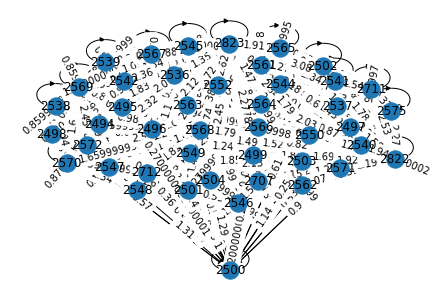

In [18]:
#Making a graph
G = nx.from_pandas_edgelist(diff_trips, "Checkout_Kiosk_ID", "Return_Kiosk_ID", "Distance", 
                            create_using = nx.DiGraph()) 
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G,'Distance')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

In [19]:
tsp = nx.approximation.traveling_salesman_problem
tsp_path = tsp(G, weight = "Distance")

In [20]:
path_dist(tsp_path)

37.580000000000005

#### Problem - Predicting Trip Duration

Based on the weather conditions, checkout and return kiosks, and month, we would like to predict the trip duration for a particular route. 

In [21]:
dt_pred = dt_full.drop(columns = ["Trip_ID", "Checkout_Date", "Checkout_Kiosk",
                                  "Return_Kiosk", "Revenue",# "Membership_Type",
                                  "Return_Kiosk_ID", "Return_Kiosk_latitude",
                                  "Return_Kiosk_longitude"])
#reducing the dataset to save on computation time
dt_pred = dt_pred.sample(frac = 0.1, replace = False, random_state=1) 

#Creating dummies for the Membership_type categorical variable
Membership_dummies = pd.get_dummies(dt_pred.Membership_Type, drop_first = True)

In [22]:
dt_pred = pd.concat([dt_pred, Membership_dummies], axis = 1, ignore_index = False)
dt_pred.head(3)

,Membership_Type,Bicycle_ID,Month,TempAvgF,DewPointAvgF,HumidityAvgPercent,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,Checkout_Kiosk_ID,Checkout_Kiosk_latitude,Checkout_Kiosk_longitude,Trip_Duration_Minutes,Distance,24-Hour-Online (Austin B-cycle),7-Day,7-Day Membership (Austin B-cycle),ACL Weekend Pass Special (Austin B-cycle),Annual (Boulder B-cycle),Annual (Broward B-cycle),Annual (Cincy Red Bike),Annual (Denver B-cycle),Annual (Denver Bike Sharing),Annual (Kansas City B-cycle),Annual (Madison B-cycle),Annual (Nashville B-cycle),Annual (San Antonio B-cycle),Annual Member (Houston B-cycle),Annual Membership (Austin B-cycle),Annual Membership (Charlotte B-cycle),Annual Membership (Fort Worth Bike Sharing),Annual Membership (GREENbike),Annual Membership (Indy - Pacers Bikeshare ),Explorer,Founding Member,Founding Member (Austin B-cycle),FunFunFun Fest 3 Day Pass,Local30,Local365,Semester Membership,Semester Membership (Austin B-cycle),Walk Up
4844,24-Hour Kiosk (Austin B-cycle),509,11,60,41,53,10,2,0.00,2504,30.24891,-97.75019,20,0.72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
126245,24-Hour Kiosk (Austin B-cycle),281,10,74,60,69,10,3,0.00,2542,30.26217,-97.72743,11,0.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105086,Annual Membership (Austin B-cycle),885,8,87,72,64,10,5,0.07,2539,30.26426,-97.74023,25,0.86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
Y = dt_pred["Trip_Duration_Minutes"]
X = dt_pred.drop(columns = ["Trip_Duration_Minutes", "Membership_Type"])

In [24]:
seed = 590
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [25]:
#lm = LinearRegression()# fit model to training data
lm = XGBClassifier()
lm.fit(X_train,y_train)

[17:30:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [26]:
y_pred = lm.predict(X_test)
predictions = [round(value) for value in y_pred]

In [27]:
accuracy = lm.score(X_test,y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 8.48%


#### Problem - Clustering similar kiosks

Here we use the clustering algorithm from networkx to find out groups of kiosks based on their popularity.

In [28]:
G2 = nx.from_pandas_edgelist(diff_trips, "Checkout_Kiosk_ID", "Return_Kiosk_ID", "NoOfTrips", 
                            create_using = nx.DiGraph()) 

In [29]:
cluster_coeff = np.array(list(nx.clustering(G2).values())).reshape(-1,1)

In [30]:
kmeans_kwargs = {"init": "random",
                 "n_init": 10,
                 "max_iter": 300,
                 "random_state": 42}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(cluster_coeff)
    sse.append(kmeans.inertia_)

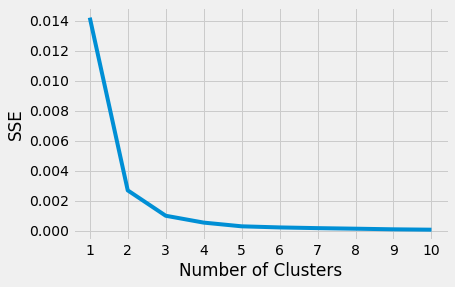

In [31]:
#Elbow Plot to get the optimum number of clusters
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [32]:
from sklearn.metrics import silhouette_score

In [33]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(cluster_coeff)
    score = silhouette_score(cluster_coeff, kmeans.labels_)
    silhouette_coefficients.append(score)

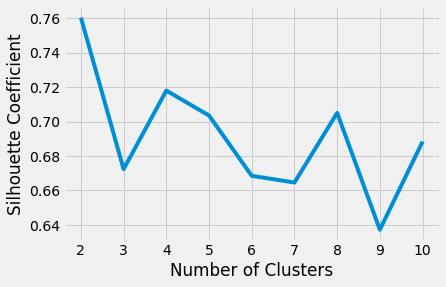

In [34]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Hence, there are only two distinct clusters in our data. In other words, there are only two kinds of kiosks present in austin based on its popularity.

In [35]:
#Final model
kmeans = KMeans(n_clusters=2, **kmeans_kwargs)
kmeans.fit(cluster_coeff)

KMeans(init='random', n_clusters=2, random_state=42)

In [36]:
color_map = list(kmeans.labels_)

In [37]:
for i,n in enumerate(color_map):
    if n == 1:
        color_map[i] = "red"
    else:
        color_map[i] = "yellow"

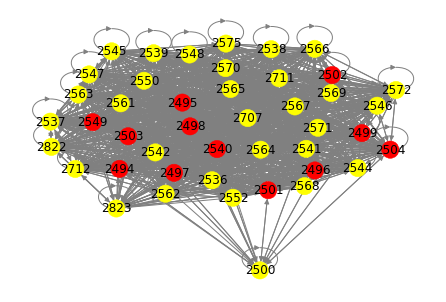

In [38]:
pos = nx.spring_layout(G2)
nx.draw(G2, pos, node_color = color_map, edge_color = "grey", with_labels = True)
plt.show()

#### Problem - Downsizing

In [39]:
#Appending a revenue column to our table
rev = []
for i in range(diff_trips.shape[0]):
    rev.append(rev_calc(diff_trips["AvgTripDuration"][i])*diff_trips["NoOfTrips"][i])
diff_trips["AvgTotalRevenue"] = [round(x,2) for x in rev]
diff_trips.head(3)

,Checkout_Kiosk_ID,Return_Kiosk_ID,NoOfTrips,Distance,AvgTripDuration,AvgTotalRevenue
0,2575,2575,1768,0.0,53.033371,23333.49
1,2499,2499,1210,0.0,75.216529,22142.76
2,2497,2497,931,0.0,59.085929,13583.07


In [40]:
#Finding which kiosks to close using optimisation
nodes = list(G2.nodes)
edges = list(G2.edges)
    
#Formulating an lp problem
prob = LpProblem(name = "Maximize_Revenue", sense = LpMaximize)

#Each vertex is a variable
v = dict() #empty dictionary to store all variables (nodes)
for i,j in enumerate(nodes):
    v[j] = LpVariable(str(nodes[i]), cat = "Binary")
    
#Objective - maximize costs
for i in nodes:
    for j in list(G2.adj[i]):
        #i is my checkout kiosk ID
        #j is my return kiosk ID
        rev = float(diff_trips[(diff_trips["Checkout_Kiosk_ID"] == i) & 
                               (diff_trips["Return_Kiosk_ID"] == j)]["AvgTotalRevenue"])
        
        prob += (v[i]+v[j])*(rev/2)


#Constraints
prob += sum(list(v.values())) <= 39
prob += sum(list(v.values())) >= 34
prob += v[2570] + v[2571] + v[2572] + v[2561] >= 2

#Solving problem
prob.solve()

1

In [41]:
elim = []
not_elim = []
for i in v.keys():
    if v[i].varValue == 0.0:
        elim.append(int(str(i)))
    elif v[i].varValue == 1.0:
        not_elim.append(int(str(i)))
print(len(not_elim))
print(len(elim))

34
10


#### Problem - Minimum Vertex Cover

In [42]:
#Formulating an lp problem
prob2 = LpProblem(name = "Minimum_Vertex_Cover", sense = LpMinimize)
    
#Each vertex is a variable
v2 = dict() #empty dictionary to store all variables (nodes)
for i,j in enumerate(nodes):
    v2[j] = LpVariable(str(nodes[i]), cat = "Binary")

#Constraints - atleast one vextex on an edge is marked as 1
for e in edges:
    if e[0] != e[1]:
        prob2 += v2[e[0]] + v2[e[1]] >= 1

#Objective - minimum no. of nodes
prob2 += sum(list(v2.values()))

prob2.solve()

1

In [43]:
value(prob2.objective)

41.0

In [44]:
skip = []
for v in prob2.variables():
    if v.varValue == 0.0:
        skip.append(int(str(v)))

In [45]:
skip

[2500, 2572, 2822]

#### References
- Travling Salesman Problem
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.traveling_salesman.traveling_salesman_problem.html
- Kmeans
https://realpython.com/k-means-clustering-python/ 
- Clustering
https://www.geeksforgeeks.org/python-clustering-connectivity-and-other-graph-properties-using-networkx/

___
## Thank You